**Note :** 

The following code is primarily for data exploration and visualization and has been helpful in understanding the data and the problem at hand. But most importantly for building the `NewsProcessor` class which is used for processing the news data. Most of the code found here is used in the `NewsProcessor` class in a more modular and optimized way. (It can be found in the `NewsProcessor.py` file in the `/util` directory)

# Imports

In [1]:
import os
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

# Configure

In [2]:
# select the language, here we use English
LANGUAGES = ['en', 'EN'] # English
PATH_NEWS_CODE = os.path.join('..', 'data', 'news_code.csv') # path to news_code.csv
PATH_NEWS = os.path.join('..', 'data', 'news_train') # path to news data

# Load data

## News Code information

In [3]:
# read the news code format file
df_code = pd.read_csv(PATH_NEWS_CODE, sep=';')

In [4]:
df_code.set_index('Code', inplace=True)
df_code.head(10)

,Name,Type
Code,,
M:3,Arts / Culture / Entertainment,Arts / Culture / Entertainment
M:GZ,Art,Arts / Culture / Entertainment
M:M1,Books,Arts / Culture / Entertainment
M:H1,Film,Arts / Culture / Entertainment
M:H0,Music,Arts / Culture / Entertainment
M:H3,Television,Arts / Culture / Entertainment
M:H6,Theater,Arts / Culture / Entertainment
M:QQ,Video Games,Arts / Culture / Entertainment
M:287,Streaming Media,Arts / Culture / Entertainment


In [5]:
df_code.Name.value_counts()

Name
Arts / Culture / Entertainment                       1
Georgia (Country)                                    1
Gabon                                                1
United Kingdom                                       1
England                                              1
                                                    ..
Pharmaceuticals & Medical Research (TRBC level 2)    1
Phones & Handheld Devices (TRBC level 4)             1
Phones & Handheld Devices (NEC) (TRBC level 5)       1
Mobile Phone Retailers (TRBC level 5)                1
Sports Results                                       1
Name: count, Length: 2516, dtype: int64

## Get news files

In [6]:
def load_news(directory: str) -> pd.DataFrame:
        """
        Load news data from all json files in the provided directory.

        Args:
            directory (str): The directory containing the json files.

        Returns:
            df (pandas.DataFrame): A dataframe containing the news data.
        """
        # initialize the dataframe (empty)
        df = pd.DataFrame()

        # iterate over all json files in the directory
        for filename in os.listdir(directory):
            # check if the file is in correct format
            if filename.endswith(".txt.gz"):
                filepath = os.path.join(directory, filename)
                with gzip.open(filepath, 'r') as f:
                    news = pd.read_json(f)

                # append the data from the current file to df
                df = pd.concat([df, pd.json_normalize(news['Items'])])

        return df

In [7]:
# load the news data
df = load_news(PATH_NEWS)
initial_length = len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337029 entries, 0 to 353472
Data columns (total 18 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   guid                 1337029 non-null  object
 1   timestamps           1337029 non-null  object
 2   data.body            1337029 non-null  object
 3   data.mimeType        1337029 non-null  object
 4   data.pubStatus       1337029 non-null  object
 5   data.language        1337029 non-null  object
 6   data.altId           1337029 non-null  object
 7   data.headline        1337029 non-null  object
 8   data.takeSequence    1337029 non-null  int64 
 9   data.versionCreated  1337029 non-null  object
 10  data.messageType     1337029 non-null  int64 
 11  data.firstCreated    1337029 non-null  object
 12  data.subjects        1337029 non-null  object
 13  data.audiences       1337029 non-null  object
 14  data.provider        1337029 non-null  object
 15  data.instancesOf     

In [8]:
print(f"Number of news articles: {len(df)}")

Number of news articles: 1337029


In [9]:
# keep only the news in appropriate languages
df = df[df['data.language'].isin(LANGUAGES)]

In [10]:
# check NaN values
print(f"Any NaN : {df.isna().sum().any()}")
# check null values
print(f"Any null : {df.isnull().sum().any()}")

Any NaN : False
Any null : False


In [11]:
print(f"Number of news articles after language filtering: {len(df)}")

Number of news articles after language filtering: 978641


In [12]:
df.head()

,guid,timestamps,data.body,data.mimeType,data.pubStatus,data.language,data.altId,data.headline,data.takeSequence,data.versionCreated,data.messageType,data.firstCreated,data.subjects,data.audiences,data.provider,data.instancesOf,data.id,data.urgency
0,S6N25P01Q_1910011UprVKT1QGhvG8trLq5tlyjTTsgt70...,"[{'source': 'AMER', 'name': 'recorded', 'times...",,text/plain,stat:usable,en,nS6N25P01Q,S.KOREA SAYS SEPT EXPORTS -11.7% VS YR EARLIER...,1,2019-10-01T00:00:00.000Z,1,2019-10-01T00:00:00.000Z,"[E:5, E:9, G:1, G:6, G:AE, G:K, G:S, I:1U, M:1...","[NP:C, NP:D, NP:E, NP:GRO, NP:M, NP:MTL, NP:O,...",NS:RTRS,[],S6N25P01Q_1910011UprVKT1QGhvG8trLq5tlyjTTsgt70...,1
2,S6N25P01Q_19093012NUAxu7xW8kMRqwtbhbuEpeJjKhRF...,"[{'source': 'AMER', 'name': 'recorded', 'times...",,text/plain,stat:usable,en,nS6N25P01Q,S.KOREA SAYS SEPT IMPORTS -5.6% VS YR EARLIER ...,2,2019-10-01T00:00:00.000Z,1,2019-09-30T23:59:50.329Z,"[E:5, E:9, G:1, G:6, G:AE, G:K, G:S, I:1U, M:1...","[NP:C, NP:D, NP:E, NP:GRO, NP:M, NP:MTL, NP:O,...",NS:RTRS,[],S6N25P01Q_19093012NUAxu7xW8kMRqwtbhbuEpeJjKhRF...,1
3,S6N25P01Q_1909301XGTWTI90nEMzDuP587SXmkbWApUG+...,"[{'source': 'AMER', 'name': 'recorded', 'times...",,text/plain,stat:usable,en,nS6N25P01Q,S.KOREA SAYS SEPT TRADE BALANCE AT PROVISIONAL...,5,2019-10-01T00:00:00.000Z,1,2019-09-30T23:59:50.329Z,"[E:5, E:9, G:1, G:6, G:AE, G:K, G:S, I:1U, M:1...","[NP:C, NP:D, NP:E, NP:GRO, NP:M, NP:MTL, NP:O,...",NS:RTRS,[],S6N25P01Q_1909301XGTWTI90nEMzDuP587SXmkbWApUG+...,1
4,S6N25P01Q_1909301mDsLfsMJ53Jhc7kbWqjF/SnmY2IV6...,"[{'source': 'AMER', 'name': 'recorded', 'times...",,text/plain,stat:usable,en,nS6N25P01Q,S.KOREA SAYS SEPT SEMICONDUCTOR EXPORTS -31.5%...,3,2019-10-01T00:00:00.000Z,1,2019-09-30T23:59:50.329Z,"[B:161, B:162, B:163, B:164, B:278, B:279, E:5...","[NP:C, NP:D, NP:E, NP:GRO, NP:M, NP:MTL, NP:O,...",NS:RTRS,[],S6N25P01Q_1909301mDsLfsMJ53Jhc7kbWqjF/SnmY2IV6...,1
5,S6N25P01Q_1909301mNovrblDSNCfS6Ui3qXYf9/vBAWjM...,"[{'source': 'AMER', 'name': 'recorded', 'times...",,text/plain,stat:usable,en,nS6N25P01Q,S.KOREA SAYS SEPT EXPORTS TO CHINA -21.8% Y/Y,4,2019-10-01T00:00:00.000Z,1,2019-09-30T23:59:50.329Z,"[E:5, E:9, G:1, G:6, G:AE, G:B1, G:K, G:S, I:1...","[NP:C, NP:D, NP:E, NP:GRO, NP:M, NP:MTL, NP:O,...",NS:RTRS,[],S6N25P01Q_1909301mNovrblDSNCfS6Ui3qXYf9/vBAWjM...,1


In [13]:
# keep only the columns needed
COLUMNS = ['data.versionCreated', 'data.headline', 'data.body', 'data.subjects']
df = df[COLUMNS]

# rename columns
df.rename(columns={'data.versionCreated': 'date', 'data.headline': 'headline', 'data.body': 'body', 'data.subjects': 'subjects'}, inplace=True)

# reset index
df.reset_index(drop=True, inplace=True)

# print the rows with body != empty
df[df['body'] != ''].head()

,date,headline,body,subjects
5,2019-10-01T00:00:00.000Z,Australian home prices rise most in 2-1/2 year...,"SYDNEY, Oct 1 (Reuters) - Australian home ...","[G:2H, G:K, M:1L, E:B, E:5, E:9, A:6, B:129, I..."
7,2019-10-01T00:00:00.000Z,"TABLE-S.Korea Sept exports fall 11.7% y/y, dow...","SEOUL, Oct 1 (Reuters) - Following are Sou...","[E:5, E:9, G:1, G:AE, G:K, I:1U, M:1L, M:R, G:..."
8,2019-10-01T00:00:02.191Z,TABLE-Si Holdings <7070.T>-2019/20 div forecast,Oct 1 (Reuters) -\r\n Si Holding...,"[B:125, B:147, B:1652, B:1691, B:261, B:266, B..."
9,2019-10-01T00:00:02.231Z,TABLE-Si Holdings <7070.T>-2019/20 group forecast,Oct 1 (Reuters) -\r\n Si Holding...,"[B:125, B:147, B:1652, B:1691, B:261, B:266, B..."
10,2019-10-01T00:00:02.238Z,TABLE-Si Holdings plc <7070.T>-2019 6-month gr...,Oct 1 (Reuters) -\r\n Si Holding...,"[B:125, B:147, B:1652, B:1691, B:261, B:266, B..."


# Initial Preprocessing

In [14]:
print(f"Number of news articles after column filtering: {len(df)}")

Number of news articles after column filtering: 978641


In [15]:
# drop the rows with same headline (keep the first one)
df.drop_duplicates(subset=['headline'], inplace=True)

# reset index
df.reset_index(drop=True, inplace=True)

print(f"Number of news articles after duplicate filtering: {len(df)}")

Number of news articles after duplicate filtering: 743620


In [16]:
print(f"Number of news without body : {len(df[df['body'] == ''])}")

Number of news without body : 396270


We are keeping news without `body` because we are only interested in the `headline` and `subjects` for this project.

### Filter subjects codes

Function to filter the subjects that are not in `df_code` : 

In [17]:
# create a set of valid subject codes from df_code
valid_subjects = set(df_code.index)

# define a function to filter the subjects
def filter_subjects(subjects: list) -> list:
    """
    Filter the subjects list to keep only the valid ones.
    
    Args:
        subjects (list): The list of subjects.
        
    Returns:
        subjects (list): The list of valid subjects.
    """

    # create a set of subjects that are present in df_code
    present_subjects = set([s for s in subjects if s in valid_subjects])
    
    # return the list of present subjects
    return list(present_subjects)

# apply the function to the subjects column
df['subjects'] = df['subjects'].apply(filter_subjects)

In [18]:
print(f"Number of news after valid (in df_code) subjects filtering: {len(df)}")

Number of news after valid (in df_code) subjects filtering: 743620


# Check empty list

In [19]:
# print number of news with empty subjects list
print(f"Number of news without subjects : {len(df[df['subjects'].apply(lambda x: len(x)) == 0])}")

Number of news without subjects : 920


In [20]:
# drop the rows with empty subjects
df = df[df['subjects'].map(len) > 0]

In [21]:
# reset index
df.reset_index(drop=True, inplace=True)

print(f"Number of news after empty subjects filtering: {len(df)}")

Number of news after empty subjects filtering: 742700


# Visualizations

## Recurring keywords

In [22]:

def find_recurring_strings(df: pd.DataFrame, column: str) -> list:
    """
    Find recurring strings in a column of a dataframe.

    Args:
        df (DataFrame): The dataframe containing the data.
        column (str): The name of the column to search for recurring strings.

    Returns:
        list: A list of recurring strings sorted by frequency.
    """
    # create a defaultdict to store the frequency of each string
    string_frequency = defaultdict(int)

    # iterate over the values in the specified column
    for value in df[column]:
        # split the value into words
        words = value.split()

        # generate all possible substrings of the value
        substrings = [words[i:j] for i in range(len(words)) for j in range(i+1, len(words)+1)]

        # count the frequency of each substring
        for substring in substrings:
            string_frequency[' '.join(substring)] += 1

    # sort the recurring strings by frequency in descending order
    recurring_strings = sorted(string_frequency.items(), key=lambda x: x[1], reverse=True)

    return recurring_strings


# find the recurring strings in the headline column
recurring_strings = find_recurring_strings(df, 'headline')

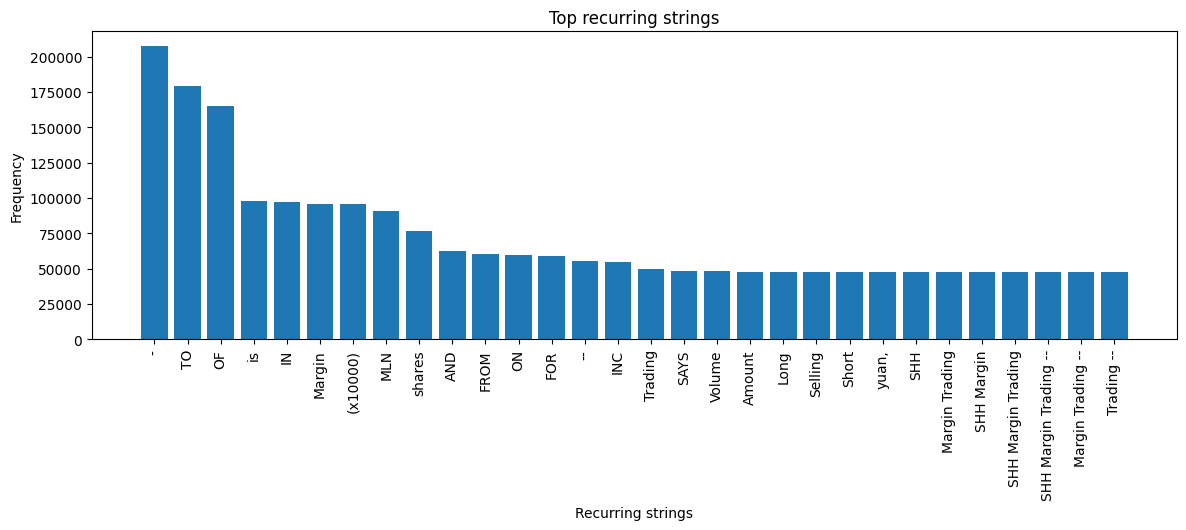

In [23]:
# plot the top recurring strings
plt.figure(figsize=(14, 4))
# first 50 strings
plt.bar([x[0] for x in recurring_strings[:30]], [x[1] for x in recurring_strings[:30]])
plt.xticks(rotation=90)
plt.xlabel('Recurring strings')
plt.ylabel('Frequency')
plt.title('Top recurring strings')
plt.show()


## Subjects distribution

In [24]:
# count the number of subjects per news and add it as a new column
df.loc[:, 'subjects_count'] = df['subjects'].apply(lambda x: len(x))

In [25]:
# statistics on the number of subjects
print("Mean number of subjects per news :", df['subjects_count'].mean())
print("Min number of subjects per news :", df['subjects_count'].min())
print("Max number of subjects per news :", df['subjects_count'].max())
print(f"Number of news with 0 subject : {len(df[df['subjects_count'] == 0])}")
print(f"Number of news with 1 subject : {len(df[df['subjects_count'] == 1])}")    

Mean number of subjects per news : 14.458838023428033
Min number of subjects per news : 1
Max number of subjects per news : 129
Number of news with 0 subject : 0
Number of news with 1 subject : 3678


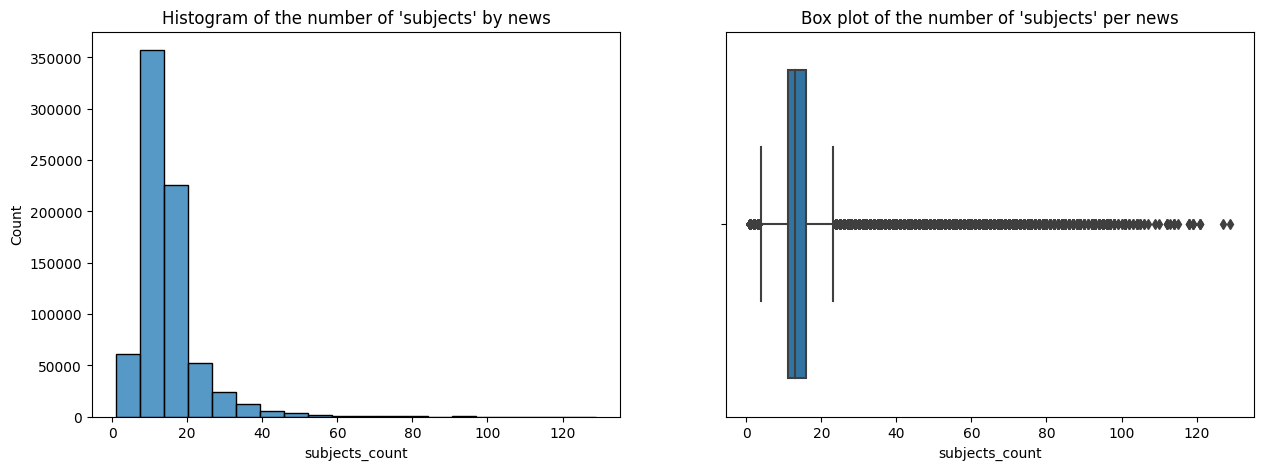

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# histogram of the frequencies of "subjects" by news
sns.histplot(data=df, x='subjects_count', bins=20, ax=ax[0])

# box plot of the number of "subjects" per news
sns.boxplot(data=df, x='subjects_count', ax=ax[1])

ax[0].set_title("Histogram of the number of 'subjects' by news")
ax[1].set_title("Box plot of the number of 'subjects' per news")

plt.show()


In [27]:
print(f"Number of news before subjects filtering: {len(df)}")

Number of news before subjects filtering: 742700


In [28]:
def filter_subjects_count(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter the dataframe to keep only the news with a number of subjects between the first and third quartiles using the interquartile range.

    Args:
        df (DataFrame): The dataframe containing the data.

    Returns:
        DataFrame: The filtered dataframe.
    """

    # calculate the first and third quartiles and the interquartile range
    Q1 = df['subjects_count'].quantile(0.25)
    Q3 = df['subjects_count'].quantile(0.75)

    # calculate the interquartile range
    IQR = Q3 - Q1

    # calculate the minimum and maximum values
    min_count = Q1 - 1.5 * IQR
    max_count = Q3 + 1.5 * IQR

    # filter out the news with 'subjects' that have a count less than min_count or greater than max_count
    df = df[(df['subjects_count'] >= min_count) & (df['subjects_count'] <= max_count)]

    # reset index
    df.reset_index(drop=True, inplace=True)
    
    # return the filtered dataframe
    return df

# apply the function to the dataframe
df = filter_subjects_count(df)

In [29]:
print(f"Size of the dataframe after subjects filtering: {len(df)}")

Size of the dataframe after subjects filtering: 661131


### Subject frequency

In [30]:
# create a df with the subjects column exploded into multiple rows (one subject per row)
df_exploded = df.explode('subjects')

# count the number of occurrences of each topic
subjects_counts = df_exploded['subjects'].value_counts()

print("Most frequent subjects :")
print(subjects_counts.head(6))

print("Least frequent subjects :")
print(subjects_counts.tail(6))

Most frequent subjects :
subjects
M:Z     520257
E:1     278003
G:4     267780
G:9     259547
G:K     248972
G:6J    238433
Name: count, dtype: int64
Least frequent subjects :
subjects
U:29      1
M:5I      1
E:V       1
B:1347    1
M:HK      1
M:BN      1
Name: count, dtype: int64


In [31]:
print(f"Number of subjects that appear only once : {len(subjects_counts[subjects_counts == 1])}")

# number of subjects that appear less than n times
n = 100
print(f"Number of subjects that appear less than {n} times : {len(subjects_counts[subjects_counts < n])}")
print(f"Number of subjects that appear more than {n} times : {len(subjects_counts[subjects_counts > n])}")

Number of subjects that appear only once : 25
Number of subjects that appear less than 100 times : 755
Number of subjects that appear more than 100 times : 1379


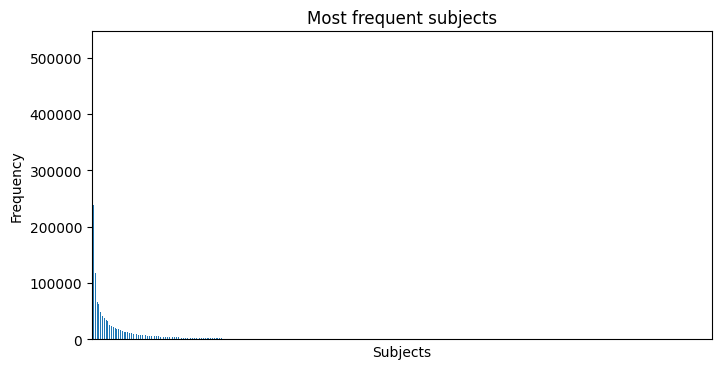

In [32]:
plt.figure(figsize=(8, 4))
subjects_counts.plot(kind='bar')
plt.title("Most frequent subjects")
plt.xlabel("Subjects")
plt.ylabel("Frequency")
plt.xticks([]) # remove tick labels
plt.show()

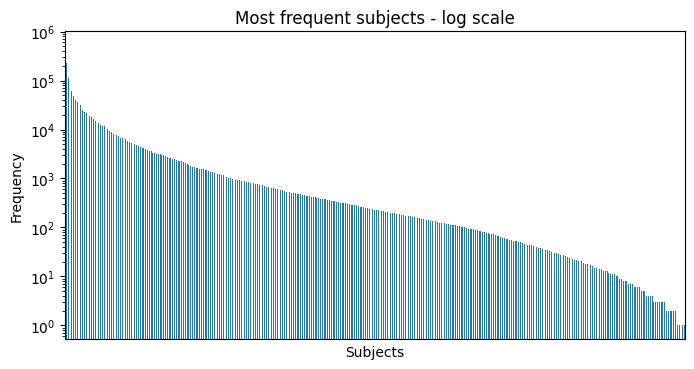

In [33]:
plt.figure(figsize=(8, 4))
subjects_counts.plot(kind='bar')
plt.yscale('log')
plt.title("Most frequent subjects - log scale")
plt.xlabel("Subjects")
plt.ylabel("Frequency")
plt.xticks([]) # remove tick labels
plt.show()

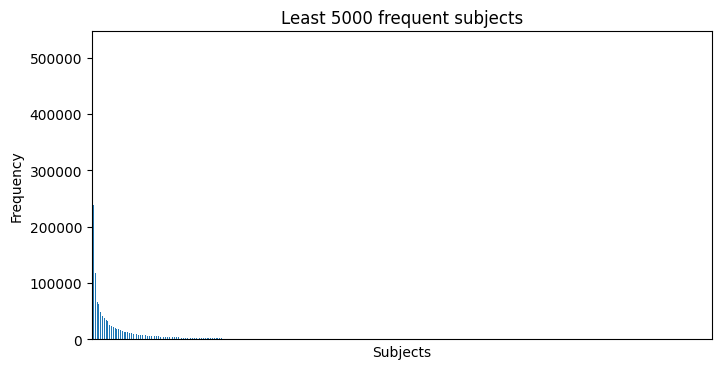

In [34]:
plt.figure(figsize=(8, 4))
subjects_counts.tail(5000).plot(kind='bar')
plt.title("Least 5000 frequent subjects")
plt.xlabel("Subjects")
plt.ylabel("Frequency")
plt.xticks([]) # remove tick labels
plt.show()

## End of preprocessing

In [35]:
print(f"Number of news deleted in the complete process: {initial_length - len(df)}")
print(f"Percentage of news deleted in the complete process: {(initial_length - len(df)) / initial_length * 100:.2f}%")

Number of news deleted in the complete process: 675898
Percentage of news deleted in the complete process: 50.55%


# Similarity computation

In this section, we will compute the similarity between a limited number of news, to try to understand how it works. Unfortunately, we cannot compute the similarity between all the news because it would take too much time, memory and disk space. We will therefore only compute the similarity between a limited number of news. That is way, in the final version of the project, we only compute the similarity between random pairs of news.

## Jacard Similarity

In [36]:
MAX_SUBJECTS = len(df_code) # maximum number of subjects to keep (here we keep all the subjects)
LIMIT = 100 # number of news to keep per subject

In [37]:
# limit the number of news to not exceed the memory limit
df_limit = df.sample(n=LIMIT, random_state=42)

# count the number of occurrences of each topic
subjects_counts = pd.Series([subject for subjects in df_limit['subjects'] for subject in subjects]).value_counts()
# select the top subjects (here we keep all the subjects)
top_subjects = subjects_counts.index[:MAX_SUBJECTS]

# create a similarity matrix between the sets of topics
mlb = MultiLabelBinarizer(classes=top_subjects)
subjects_matrix = mlb.fit_transform(df_limit['subjects'])

In [38]:
# convert the matrix to a boolean matrix for memory efficiency
subjects_matrix = subjects_matrix.astype(bool)

### Calculate complete distance matrix (Jacard)

In [39]:
jaccard_sim_matrix = pairwise_distances(subjects_matrix, metric='jaccard', n_jobs=-1)

In [40]:
print("Similarity matrix between the sets of subjects :")
print(jaccard_sim_matrix)

Similarity matrix between the sets of subjects :
[[0.         0.76470588 0.95833333 ... 0.82608696 1.         0.95238095]
 [0.76470588 0.         0.95652174 ... 0.81818182 1.         0.95      ]
 [0.95833333 0.95652174 0.         ... 0.84615385 0.81481481 0.91304348]
 ...
 [0.82608696 0.81818182 0.84615385 ... 0.         0.90322581 0.92      ]
 [1.         1.         0.81481481 ... 0.90322581 0.         0.96428571]
 [0.95238095 0.95       0.91304348 ... 0.92       0.96428571 0.        ]]


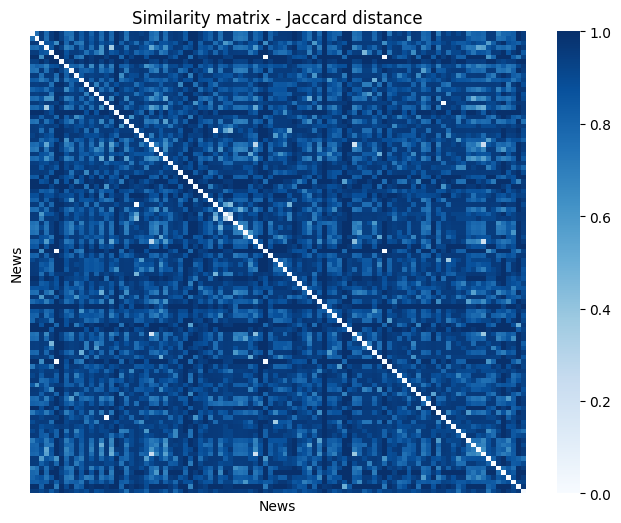

In [41]:
plt.figure(figsize=(8, 6))
sns.heatmap(jaccard_sim_matrix, cmap='Blues', annot=False, xticklabels=False, yticklabels=False)
plt.title("Similarity matrix - Jaccard distance")
plt.xlabel("News")
plt.ylabel("News")
plt.show()

A value of 0 means that the two sets are identical, i.e. they have the same elements. A value of 1 means that the two sets have no elements in common.

In our case, to find the most similar news pairs, we can look for the indices (i, j) of the distance matrix with the lowest value (closest to 0). These news pairs will have the highest similarity (lowest dissimilarity).

## Cosine similarity

In [42]:
# convert to boolean matrix for memory efficiency
subjects_matrix = subjects_matrix.astype(bool)

### Calculate complete distance matrix (Cosine)

In [43]:
cosine_sim_matrix = cosine_similarity(subjects_matrix)

In [44]:
print("Cosine similarity matrix between the sets of subjects :")
print(cosine_sim_matrix)

Cosine similarity matrix between the sets of subjects :
[[1.         0.38138504 0.0805823  ... 0.30151134 0.         0.09090909]
 [0.38138504 1.         0.08451543 ... 0.31622777 0.         0.09534626]
 [0.0805823  0.08451543 1.         ... 0.26726124 0.31497039 0.16116459]
 ...
 [0.30151134 0.31622777 0.26726124 ... 1.         0.1767767  0.15075567]
 [0.         0.         0.31497039 ... 0.1767767  1.         0.07106691]
 [0.09090909 0.09534626 0.16116459 ... 0.15075567 0.07106691 1.        ]]


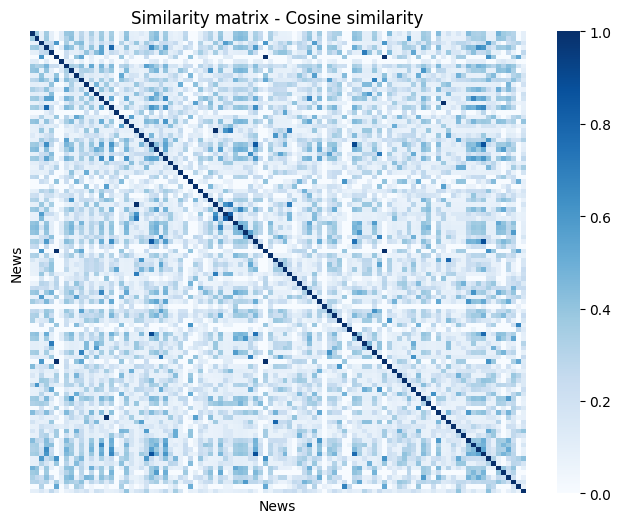

In [45]:
plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim_matrix, cmap='Blues', annot=False, xticklabels=False, yticklabels=False)
plt.title("Similarity matrix - Cosine similarity")
plt.xlabel("News")
plt.ylabel("News")
plt.show()

1 represents maximum similarity between vectors and 0 represents minimum similarity. This means that the closer the cosine similarity value is to 1, the more similar the vectors are, while the closer it is to 0, the more different they are.

### Inverse matrix

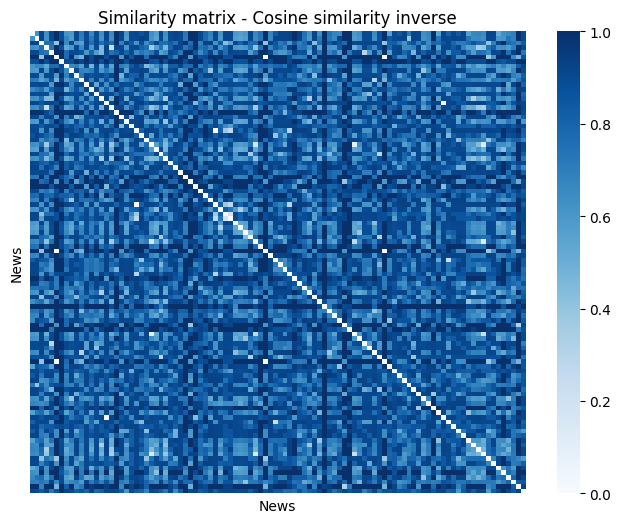

In [46]:
# invert the values for the heatmap plot to be comparable with the Jaccard similarity matrix
max_val = np.max(cosine_sim_matrix)
cosine_sim_matrix_inverse = np.abs(cosine_sim_matrix - max_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim_matrix_inverse, cmap='Blues', annot=False, xticklabels=False, yticklabels=False)
plt.title("Similarity matrix - Cosine similarity inverse")
plt.xlabel("News")
plt.ylabel("News")
plt.show()

# Explore training data

Here, we will explore the training data generated (random pairs), to see if we can find any patterns or insights that can help us in the project.

Note : The tested `pairs_{}.csv` file must be csv file **with both similarities labels computed**, this is done by changing the constant `USE_JACCARD` and `USE_COSINE` in the `create_pairs.py` or `process.py` script to `True`.

In [47]:
DIRECTORY = os.path.join("..", "data", "pairs")
FILENAME =  "pairs_5000.csv"

## Explore Jacard similarity

In [48]:
df_pairs = pd.read_csv(os.path.join(DIRECTORY, FILENAME), index_col=0)
df_pairs.head()

,news1,guid_news2,news2,similarity_jaccard,similarity_cosine
guid_news1,,,,,
FWN28G0RL_1912091si3KKhm+3Gz9xhUhzYDVc2rDq9sWsTuXrYUcI,ATLAS COPCO AB <ATCOa.ST>: JP MORGAN RAISES TA...,FWN29C15I_2001081c/fHtHwuFEAyOpYbUSGG8aykyiNYw...,OK PLAY INDIA LTD - THERE HAS BEEN NO LOSS OR ...,0.511298,0.080582
T9N277025_1912191blazZxF/z9qKPP1Xhvbzxd7bvgGHDl7qVYn2A,BOJ GOV KURODA: NO RISK FOR CHINA ECONOMY TO ...,ASA00B8C__20013014BXbvn6Wh4uk8SpCfdNKX62GsCpJq...,PROOFPOINT INC <PFPT.O> SEES FY 2020 REVENUE $...,0.545589,0.201802
NSE200115_2001156Fjw9nPBkXuoe0j+5gtGsyEOapNL3rg6b8snsH,"NSEI Block Deal SOBHA LTD 115,470 shares at 43...",L1N29J02S_2001142WkkkKpd9YarSOZmIUx6zMRLt+5VGC...,Soccer-Jordi Cruyff named coach of Ecuador,0.525031,0.129099
AZN000C87_19120126EYFBwXEylCbOW3vWhMpRqQHWD65VmhNaBTWD,Australia Stock Exchange release from KATANA <...,L4N29F2AM_20011323d6ZS44+z1xyzK0z+ISxrx2a93acP...,Thai elephants march in silence for Australian...,0.512618,0.084515
ASA005UE__1912061HitSoABi5bTEOzqFwEdoRC8rEHUeRD7LA1Fs9,HI-CRUSH INC. ANNOUNCES CHIEF FINANCIAL OFFICE...,AZN02876T_200107237CZhFObMFPkYp8rwNLWAGXnfBUhq...,Malaysia sells govt bonds maturing in 2027 at ...,0.511298,0.080064


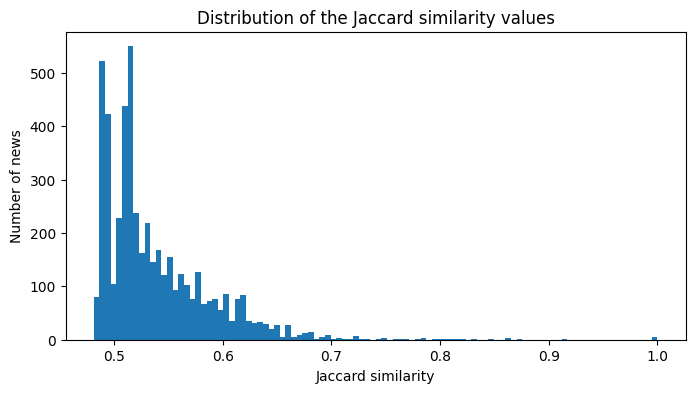

In [49]:
plt.figure(figsize=(8, 4))
plt.hist(df_pairs['similarity_jaccard'], bins=100) # bins is the number of bars
plt.title("Distribution of the Jaccard similarity values")
plt.xlabel("Jaccard similarity")
plt.ylabel("Number of news")
plt.show()

## Explore cosine similarity

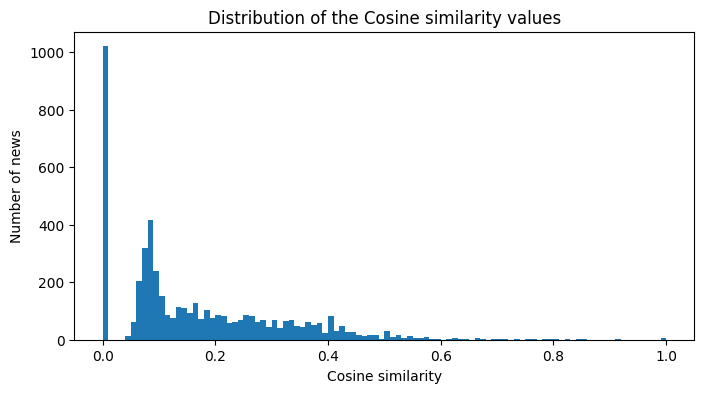

In [50]:
plt.figure(figsize=(8, 4))
plt.hist(df_pairs['similarity_cosine'], bins=100)
plt.title("Distribution of the Cosine similarity values")
plt.xlabel("Cosine similarity")
plt.ylabel("Number of news")
plt.show()

## Explore both similarity

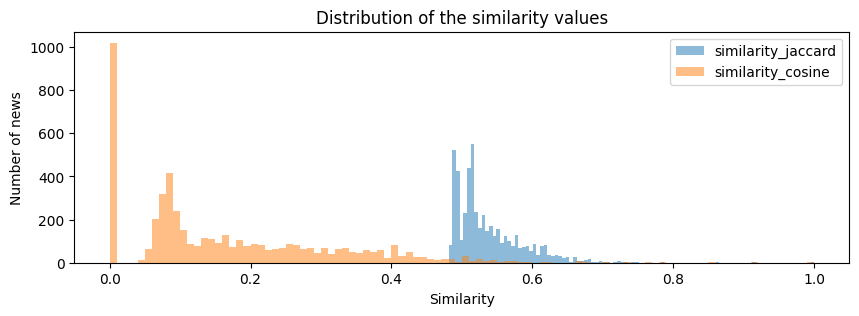

In [51]:
column1 = "similarity_jaccard"
column2 = "similarity_cosine"

plt.figure(figsize=(10, 3))
plt.hist(df_pairs[column1], bins=100, alpha=0.5, label=column1)
plt.hist(df_pairs[column2], bins=100, alpha=0.5, label=column2) 
plt.title("Distribution of the similarity values")
plt.xlabel("Similarity")
plt.ylabel("Number of news")
plt.legend()
plt.show()